In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import qt3utils.experiments.cwodmr
import qt3utils.nidaq.config

In [ ]:
import qcsapphire
import qt3rfsynthcontrol
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
pulser = qcsapphire.Pulser('COM10')
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [ ]:
trigger_pulser_channel = None
trigger_DAQ_terminal = None

rf_on_off_period = 10e-3

cwodmr = qt3utils.experiments.cwodmr.CWODMR(rfsynth, 
                                            freq_low = 2846e6, 
                                            freq_high = 2890e6, 
                                            freq_step = 4e6,
                                            sample_period = rf_on_off_period) 



In [ ]:
qt3utils.nidaq.config.reset_daq('Dev1')

In [ ]:
sample_period = 1e-6 #minimum is 0.1e-6
clock_rate = int(1./sample_period) 
N_samples = int(1 * clock_rate) #X seconds of data per frequency
daq_time = N_samples / clock_rate #total amount of time of data acquisition for each counter task
N_cycles =  daq_time /cwodmr.sample_period 
N_samples_per_cycle = cwodmr.sample_period * clock_rate
rf_power = -15


In [ ]:
print(cwodmr.sample_period)
print(clock_rate)
print(N_samples)
print(daq_time)
print(N_cycles)
print(N_samples_per_cycle)

In [ ]:
edge_config = qt3utils.nidaq.config.EdgeCounter()
edge_config.configure_di_clock(clock_rate = clock_rate)

edge_config.configure_counter_period_measure(edge_config.clock_task_config['clock_channel_name'], 
                                             N_samples_to_acquire_or_buffer_size= N_samples,
                                            trigger_terminal=trigger_DAQ_terminal)


edge_config.create_counter_reader()

In [ ]:
def run_scan():
    
    edge_config.clock_task.start()
    data = []

    for freq in cwodmr.frequencies:
        print(freq)
        rfsynth.set_channel_fixed_output(0, rf_power, freq)
        rfsynth.rf_on(0)
        time.sleep(0.1) #wait for RF box to turn on
        data_buffer = np.zeros(N_samples)
        edge_config.counter_task.start()
        time.sleep(daq_time*1.1)
        read_samples = edge_config.counter_reader.read_many_sample_double(
                                data_buffer,
                                number_of_samples_per_channel=N_samples,
                                timeout=5)
        rfsynth.rf_off(0)
        time.sleep(0.05) #wait for RF box
        edge_config.counter_task.stop()
        data.append([freq, data_buffer])
    edge_config.clock_task.stop()
    
    return data


In [ ]:

def update_rf_pulse(rf_width):
    
    if rf_width > 0:
        cwodmr.setup_qcsapphire_pulser(pulser, 'B', trigger_channel = trigger_pulser_channel,
                                   rf_pulse_width=rf_width, 
                                   rf_pulse_delay = 0,
                                   qcsapphire_system_buffer=0)

    else:
        pulser.channel('B').state(0)
    pulser.multiplex(['C','B'], 'D')
    pulser.channel('D').state(1)

In [ ]:
cwodmrs_summed = []
cwodmrs_raw = []

rf_widths = [ 0.5]

for rfw in rf_widths:
    print(f'RF pulse width {rfw}')
    update_rf_pulse(rfw)
    scan_data = run_scan()
    summed_data = {data_per_freq[0]:data_per_freq[1].sum()/daq_time for data_per_freq in scan_data}
    cwodmrs_summed.append(summed_data)
    cwodmrs_raw.append(scan_data)

In [ ]:
for rf, summed_data in zip(rf_widths, cwodmrs_summed):
    plt.plot(summed_data.keys(), summed_data.values(), label = rf)
    
plt.legend()

In [ ]:
cwodmrs_raw[0]

In [ ]:
print(cwodmr.sample_period)
print(clock_rate)
print(N_samples)
print(daq_time)
print(N_cycles)
print(N_samples_per_cycle)

2870000000.0
2846000000.0


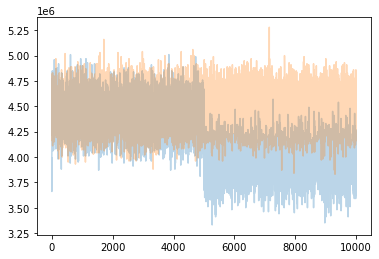

In [33]:
shift = 1500
data  = cwodmrs_raw[0]

freq = data[6][0]
trace = data[6][1]

print(freq)
data_buffer_by_cycles = np.roll(trace,shift).reshape((int(N_cycles), int(N_samples_per_cycle)))
plt.plot(data_buffer_by_cycles.mean(axis=0) * clock_rate, alpha = 0.3)


freq = data[0][0]
trace = data[0][1]

print(freq)
data_buffer_by_cycles = np.roll(trace,shift).reshape((int(N_cycles), int(N_samples_per_cycle)))
plt.plot(data_buffer_by_cycles.mean(axis=0) * clock_rate, alpha = 0.3)
# print(data[0][0])
# data_buffer_by_cycles = np.roll(data[0][1], shift).reshape((int(N_cycles), int(N_samples_per_cycle)))
# plt.plot(data_buffer_by_cycles.mean(axis=0) * clock_rate, alpha = 0.3)

In [ ]:
shift = 10000 - 2700
data  = cwodmrs_raw[1]

freq = data[6][0]
trace = data[6][1]

print(freq)
data_buffer_by_cycles = np.roll(trace,shift).reshape((int(N_cycles), int(N_samples_per_cycle)))
plt.plot(data_buffer_by_cycles.mean(axis=0) * clock_rate, alpha = 0.3)


freq = data[0][0]
trace = data[0][1]

print(freq)
data_buffer_by_cycles = np.roll(trace,shift).reshape((int(N_cycles), int(N_samples_per_cycle)))
plt.plot(data_buffer_by_cycles.mean(axis=0) * clock_rate, alpha = 0.3)
# print(data[0][0])
# data_buffer_by_cycles = np.roll(data[0][1], shift).reshape((int(N_cycles), int(N_samples_per_cycle)))
# plt.plot(data_buffer_by_cycles.mean(axis=0) * clock_rate, alpha = 0.3)

In [ ]:
shift = 800
data  = cwodmrs_raw[2]

freq = data[6][0]
trace = data[6][1]

print(freq)
data_buffer_by_cycles = np.roll(trace,shift).reshape((int(N_cycles), int(N_samples_per_cycle)))
plt.plot(data_buffer_by_cycles.mean(axis=0) * clock_rate, alpha = 0.3)


freq = data[0][0]
trace = data[0][1]

print(freq)
data_buffer_by_cycles = np.roll(trace,shift).reshape((int(N_cycles), int(N_samples_per_cycle)))
plt.plot(data_buffer_by_cycles.mean(axis=0) * clock_rate, alpha = 0.3)
# print(data[0][0])
# data_buffer_by_cycles = np.roll(data[0][1], shift).reshape((int(N_cycles), int(N_samples_per_cycle)))
# plt.plot(data_buffer_by_cycles.mean(axis=0) * clock_rate, alpha = 0.3)

In [ ]:
shift = 0
data  = cwodmrs_raw[4]
print(data[6][0])
data_buffer_by_cycles = np.roll(data[4][1], shift).reshape((int(N_cycles), int(N_samples_per_cycle)))
plt.plot(data_buffer_by_cycles.mean(axis=0) * clock_rate, alpha = 0.3)

# print(data[0][0])
# data_buffer_by_cycles = np.roll(data[0][1], shift).reshape((int(N_cycles), int(N_samples_per_cycle)))
# plt.plot(data_buffer_by_cycles.mean(axis=0) * clock_rate, alpha = 0.3)